# Imports

In [15]:
# Common
import numpy as np
import pandas as pd
from typing import List, Tuple

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Image Processing
import cv2
from PIL import Image

# Constants

In [16]:
RESULTS_1 = '/kaggle/input/horse-riding-jumping-walking/sample_1_results.csv'
RESULTS_2 = '/kaggle/input/horse-riding-jumping-walking/sample_2_results.csv'
RESULTS_3 = '/kaggle/input/horse-riding-jumping-walking/sample_3_results.csv'
RESULTS_4 = '/kaggle/input/horse-riding-jumping-walking/sample_4_results.csv'
HORSE_HH_METERS = 1.524 # 5Feet

# Utils

In [17]:
def plt_img(image, cmap="gray", flip_x_axis=False, flip_y_axis=False):
    """Display an image using matplotlib"""
    plt.imshow(image, cmap)
    if flip_y_axis:
        plt.gca().invert_yaxis() 
    if flip_x_axis:
        plt.gca().invert_xaxis() 
    plt.axis('on')
    plt.show()


def plt_frame_points(df_row, img_width=640, img_height=360, radius=5, thickness=2):
    test_row = df_row
    x_min, y_min, x_max, y_max = test_row.bbox
    
    img = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=(255, 0, 0), thickness=thickness)
    
    for col_name in test_row.index[2:-2]:
        r,g,b = parse_color(col_name)
        x, y = test_row[col_name] if test_row[col_name] else (0,0)
        cv2.circle(img, (x, y), radius=radius, color=(b,g,r), thickness=-1)
    
    plt_img(img)


# Function to safely convert a string to a list of integers
def parse_bbox(value):
    try:
        # Remove square brackets and split by spaces, then convert to integers
        return list(map(int, value.strip('[]').split()))
    except Exception as e:
        return []

def parse_color(column_name):
    # Split the string by underscores and convert each part to an integer
    try:
        return tuple(map(int, column_name.split('_')))
    except ValueError:
        return (0,0,0)

def plt_cartesian_coord_graph(points):
    x_points = [x for x, y in points]
    y_points = [y for x, y in points]

    plt.scatter(x_points, y_points)
    plt.axis("equal")
    plt.title("Transformed Cartesian Coordinates (Origin Bottom-Left)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def plt_pixel_and_cartesian_graph(point_dict):
    # Plot Pixel Coordinates
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    for color, (x, y) in points.items():
        plt.scatter(x, y, label=color)
        plt.text(x, y, f"{color} ({x}, {y})", fontsize=9, ha='right')
    plt.gca().invert_yaxis()  # Pixel coordinate y-axis is inverted
    plt.axis("equal")
    plt.title("Pixel Coordinates (Origin Top-Left)")
    plt.xlabel("X (Pixels)")
    plt.ylabel("Y (Pixels)")
    plt.legend()
    
    # Plot Cartesian Coordinates (transformed)
    plt.subplot(1, 2, 2)
    for color, (x, y) in cartesian_points.items():
        plt.scatter(x, y, label=color)
        plt.text(x, y, f"{color} ({x}, {y})", fontsize=9, ha='right')
    plt.axis("equal")
    plt.title("Transformed Cartesian Coordinates (Origin Bottom-Left)")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    
    plt.tight_layout()
    plt.show()


def pixel_to_cartesian(pixel_points: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    # Find the maximum y-value to determine the height of the coordinate space
    max_y = max(y for _, y in pixel_points)
    
    # Transform each point, except for (0, 0)
    cartesian_points = [
        (x, max_y - y) if (x, y) != (0, 0) else (x, y)  # Keep (0, 0) unchanged
        for x, y in pixel_points
    ]
    
    return cartesian_points


def calculate_horse_hh_px(frame_data, horse_hh_meters):
    if not frame_data["255_51_255"]:
        return 0
    
    # 1. Extract detected horse bounding box
    _, _, _, y_max = test_row.bbox

    # 2. Extract horse withers px pts
    _,y = frame_data["255_51_255"]

    # 3. Calculate height
    horse_height_px = y_max - y
    px_to_m_scale = (horse_hh_meters / horse_height_px)
    
    return px_to_m_scale


def get_highest_points(points_dict):
    highest_points = {}
    
    for color, points in points_dict.items():
        # Find the point with the maximum y-coordinate
        highest_point = max(points, key=lambda p: p[1])
        highest_points[color] = highest_point
    
    return highest_points


def find_highest_color(highest_points):
    # Find the color with the maximum y-coordinate value
    highest_color = max(highest_points, key=lambda color: highest_points[color][1])
    return highest_color


def find_highest_jump_height(peak_analysis_data, px_to_m_scale):
    # 1. Find heightest points for each pose
    highest_points_dict = get_highest_points(peak_analysis_data)

    # 2. Find heightest peak
    highest_color = find_highest_color(highest_points_dict)

    # 3. Get heighest y-axis value
    _, y = highest_points_dict[highest_color]

    # 4. Calculate jump height
    return y * px_to_m_scale


def meters_to_feet(meters):
    return meters * 3.28084

## Step1: Read data & Format

In [18]:
df = pd.read_csv(RESULTS_1)

# Sort Values w.r.t frames numbers
df = df.sort_values(by='frame_name', ascending=True)

# Format bbox & calculate area values
for idx, row in df.iterrows():
    # Parse the bounding box (assuming it is in the form 'x y w h')
    bbox = parse_bbox(row['bbox'])
    
    # Calculate the bounding box area (w * h)
    width = 0
    height = 0
    if len(bbox) > 0:
        x, y, w, h = bbox
        width = w
        height = h

    # Update the DataFrame
    df.at[idx, 'bbox'] = bbox
    df.at[idx, 'width'] = width 
    df.at[idx, 'height'] = height 

# Drop rows where the 'bbox' column contains an empty list
df = df[df['bbox'].apply(lambda x: x != [])]

# Change color column's type
for col in df.columns[2:-2]:
    df[col] = df[col].apply(
        lambda x: tuple(map(int, x.strip('()').split(','))) if pd.notnull(x) else None
    )

df.head()

,frame_name,bbox,255_128_0,255_153_51,255_178_102,230_230_0,255_153_255,153_204_255,255_102_255,255_51_255,...,255_51_51,153_255_153,102_255_102,51_255_51,0_255_0,0_0_255,255_0_0,255_255_255,width,height
9,66,"[96, 154, 229, 233]","(226, 156)","(225, 156)","(221, 154)","(218, 154)","(233, 163)","(214, 172)","(144, 176)","(206, 159)",...,"(187, 214)","(206, 212)","(134, 211)","(151, 210)","(183, 227)","(197, 222)","(134, 223)","(162, 224)",229.0,233.0
8,99,"[131, 149, 234, 230]","(227, 155)","(224, 160)","(216, 151)","(218, 153)","(233, 163)","(213, 173)","(141, 175)","(202, 164)",...,"(188, 213)","(211, 211)","(138, 206)","(155, 209)","(180, 226)","(201, 221)","(140, 225)","(166, 224)",234.0,230.0
88,132,"[130, 149, 236, 232]","(227, 153)","(222, 154)","(215, 150)","(216, 150)","(232, 162)","(214, 170)","(145, 174)","(200, 164)",...,"(192, 213)","(192, 215)","(159, 211)","(143, 208)","(208, 223)","(185, 226)","(171, 226)","(151, 227)",236.0,232.0
23,165,"[132, 148, 238, 232]",None,"(223, 158)",None,"(219, 153)","(228, 162)","(214, 170)","(144, 176)","(201, 162)",...,None,"(197, 212)","(161, 212)","(148, 210)","(215, 225)","(190, 221)","(171, 228)","(157, 228)",238.0,232.0
28,198,"[133, 148, 241, 235]",None,None,None,None,"(184, 180)","(212, 171)","(148, 175)","(196, 168)",...,"(219, 207)","(218, 209)","(153, 212)","(155, 213)","(224, 226)","(191, 219)","(165, 223)","(166, 229)",241.0,235.0


## Step2: Shift Bounding Box & Its points to the origin

In [19]:
# Step 1: Make a copy of 'df' as 'shifted_df'
shifted_df = df.copy()

# Step 2: Loop through each row and perform the shifting operations
for idx, test_row in shifted_df.iterrows():
    # Extract the bounding box values
    x_min, y_min, x_max, y_max = test_row.bbox

    # Shift the rectangle to the image origin (0, 0)
    new_x_min = 0
    new_y_min = 0
    new_x_max = x_max - x_min
    new_y_max = y_max - y_min
    
    # Update the bounding box in shifted_df
    shifted_df.at[idx, 'bbox'] = (new_x_min, new_y_min, new_x_max, new_y_max)

    # Iterate through columns from index 2 to the second-to-last column (color columns)
    for col_name in test_row.index[2:-2]:
        # Parse the color column name to get RGB values
        r, g, b = parse_color(col_name)
        
        # If the column has pixel points (non-null)
        if pd.notnull(test_row[col_name]):
            x, y = test_row[col_name]  # Original coordinates
            
            # Shift the coordinates to the new bounding box origin
            updated_x, updated_y = (x - x_min, y - y_min)
            
            # Update the color column with the new coordinates (x, y)
            shifted_df.at[idx, col_name] = (updated_x, updated_y)

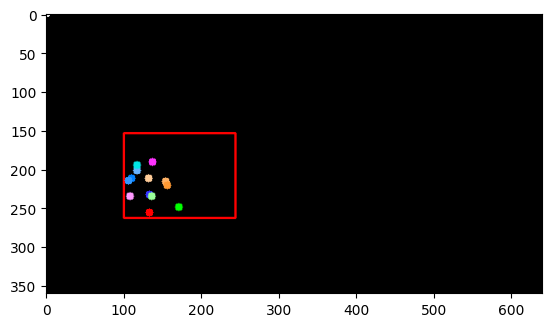

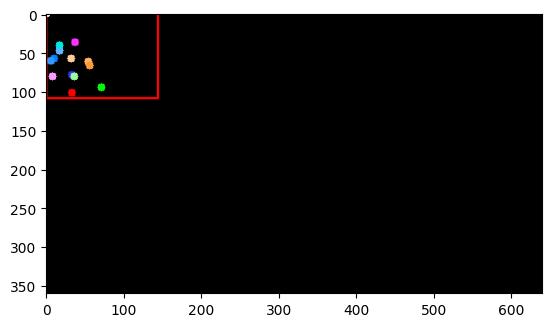

In [20]:
plt_frame_points(df.iloc[23])
plt_frame_points(shifted_df.iloc[23])

## Step3: Scaling Points

In [21]:
def get_scale_ratio(current_frame, largest_frame):
    current_width, current_height = current_frame
    largest_width, largest_height = largest_frame

    # Calculate the differences in width and height
    width_diff = largest_width - current_width
    height_diff = largest_height - current_height

    if height_diff <= width_diff:
        # Scale based on height
        scale_ratio_height = largest_height / current_height
        scale_ratio_width = scale_ratio_height * (current_width / current_height)  # Maintain aspect ratio
    else:
        # Scale based on width
        scale_ratio_width = largest_width / current_width
        scale_ratio_height = scale_ratio_width * (current_height / current_width)  # Maintain aspect ratio

    return scale_ratio_width, scale_ratio_height



def get_fixed_scale_ratio(current_width, current_height, target_width: int = 120, target_height: int = 80):
    # Calculate scale ratios for width and height
    width_ratio = target_width / current_width if current_width != 0 else 1
    height_ratio = target_height / current_height if current_height != 0 else 1
    
    return width_ratio, height_ratio

In [22]:
# largest_width = df.loc[df['width'].idxmax()]["width"]
# largest_height = df.loc[df['height'].idxmax()]["height"]

# Step 1: Make a copy for 'scaled_df'
scaled_df = shifted_df.copy()

# Step 2: Loop through each row and perform the scaling operations
for idx, test_row in scaled_df.iterrows():
    x_min, y_min, x_max, y_max = test_row.bbox
    
    # Step3: Calculate the scale ratio
    current_width = x_max
    current_height = y_max
    
    ratio_width, ratio_height = get_fixed_scale_ratio(current_width, current_height)
    # ratio_width, ratio_height = get_scale_ratio((current_width, current_height), (largest_width, largest_height))
    
    scaled_df.at[idx, 'width'] = int(current_width * ratio_width)
    scaled_df.at[idx, 'height'] = int(current_height * ratio_height)
    
    # Step4: Update bbox values
    new_x_min = int(x_min * ratio_width)
    new_y_min = int(y_min * ratio_height)
    new_x_max = int(x_max * ratio_width)
    new_y_max = int(y_max * ratio_height)
    scaled_df.at[idx, 'bbox'] = (new_x_min, new_y_min, new_x_max, new_y_max)
    
    # Step5: Iterate pose points
    for col_name in test_row.index[2:-2]:
        # If the column has pixel points (non-null)
        if pd.notnull(test_row[col_name]):
            x, y = test_row[col_name]
            updated_x, updated_y = (int(x * ratio_width), int(y * ratio_height))
            scaled_df.at[idx, col_name] = (updated_x, updated_y)

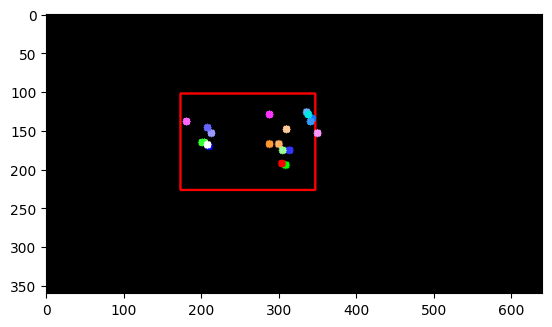

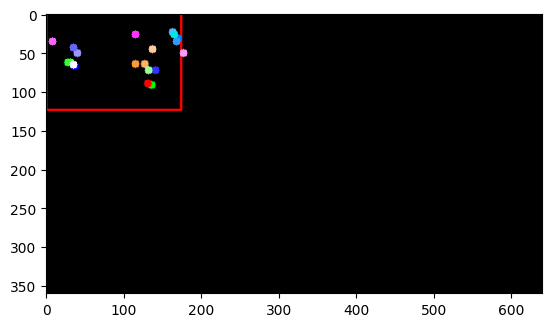

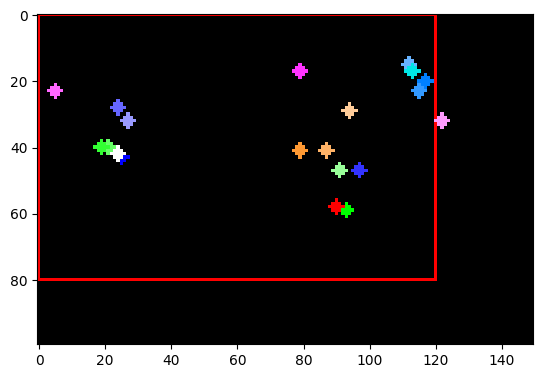

In [23]:
idx = -70
plt_frame_points(df.iloc[idx])
plt_frame_points(shifted_df.iloc[idx])
plt_frame_points(scaled_df.iloc[idx], img_width=150, img_height=100, radius=2, thickness=1)

## Step4: Transform Pixel Points to Cartesian Coordinates

In [24]:
hoof_1 = []
hoof_2 = []
hoof_3 = []
hoof_4 = []
withers = []

# Step 2: Loop through each row and perform the shifting operations
for idx, test_row in scaled_df.iterrows():
    frame_name = test_row["frame_name"]

    pt17 = test_row["0_255_0"] if test_row["0_255_0"] else (0,0)
    pt18 = test_row["0_0_255"] if test_row["0_0_255"] else (0,0)
    pt19 = test_row["255_0_0"] if test_row["255_0_0"] else (0,0)
    pt20 = test_row["255_255_255"] if test_row["255_255_255"] else (0,0)
    pt16 = test_row["255_51_255"] if test_row["255_51_255"] else (0,0)

    pixel_points = [pt17, pt18, pt19, pt20, pt16]
    cartesian_points = pixel_to_cartesian(pixel_points)

    hoof_1.append((cartesian_points[0][0] + frame_name, cartesian_points[0][1]))
    hoof_2.append((cartesian_points[1][0] + frame_name, cartesian_points[1][1]))
    hoof_3.append((cartesian_points[2][0] + frame_name, cartesian_points[2][1]))
    hoof_4.append((cartesian_points[3][0] + frame_name, cartesian_points[3][1]))
    withers.append((cartesian_points[4][0] + frame_name, cartesian_points[4][1]))

## Step5: Path Analysis

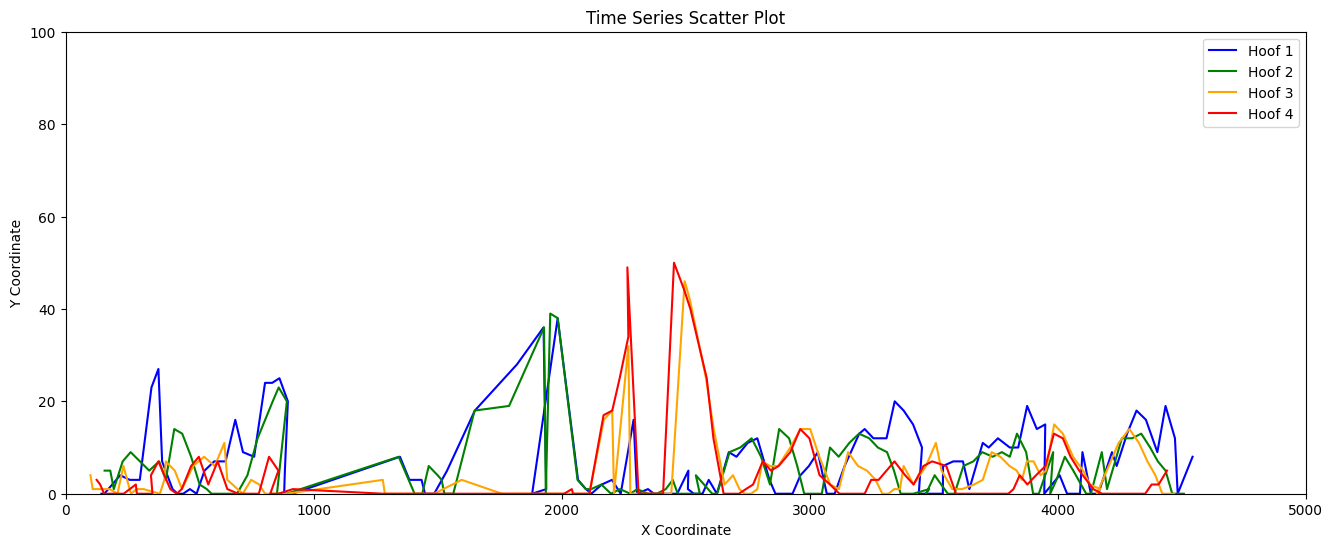

In [25]:
# Combine all data for plotting
all_data = [hoof_1, hoof_2, hoof_3, hoof_4]
colors = ['blue', 'green', 'orange', 'red']
labels = ['Hoof 1', 'Hoof 2', 'Hoof 3', 'Hoof 4']

# Plot each list with different colors
plt.figure(figsize=(16, 6))
for data, color, label in zip(all_data, colors, labels):
    x_points, y_points = zip(*data)  # Unpack x and y coordinates
    plt.plot(x_points, y_points, color=color, label=label)

# Set equal scaling for x and y axes
# plt.gca().set_aspect('equal', adjustable='box')

# Set equal scaling for x and y axes with modified limits
plt.gca().set_aspect('auto')  # Allows better fit with non-uniform scales
plt.xlim(0, 5000)   # Adjusted x-axis limit for a closer view, tweak as needed
plt.ylim(0, 100)   # Adjusted y-axis limit to fit y range exactly

# Adding titles and labels
plt.title("Time Series Scatter Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

# Save the plot with high resolution (e.g., 300 dpi for HD)
# plt.savefig('high_resolution_plot.png', dpi=300)

# Show the plot
plt.show()

### Highest Peak Analysis

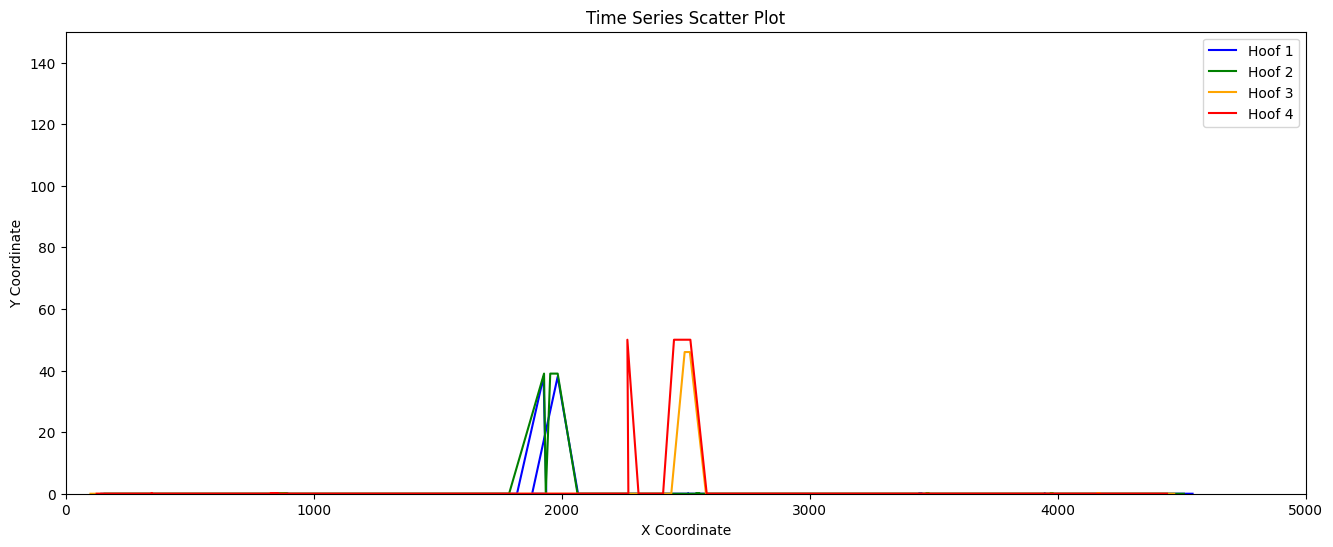

In [26]:
# Plot each list with different colors
plt.figure(figsize=(16, 6))

peak_analysis_data = {}

# Iterate through each hoe data, color, and label
for data, color, label in zip(all_data, colors, labels):
    # Find the highest y value (peak) for each hoe
    peak_y = max(data, key=lambda point: point[1])[1]
    
    # Modify the y values based on the 75% threshold
    modified_data = [(x, 0 if y <= 0.75 * peak_y else peak_y) for x, y in data]

    # Append the data
    peak_analysis_data[color] = modified_data
    
    # Unpack the modified x and y points
    x_points, y_points = zip(*modified_data)
    
    # Plot the data with the modified y points
    plt.plot(x_points, y_points, color=color, label=label)

# Set equal scaling for x and y axes with modified limits
plt.gca().set_aspect('auto')  # Allows better fit with non-uniform scales
plt.xlim(0, 5000)   # Adjusted x-axis limit for a closer view, tweak as needed
plt.ylim(0, 150)    # Adjusted y-axis limit to fit y range exactly

# Adding titles and labels
plt.title("Time Series Scatter Plot")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()

# Show the plot
plt.show()


## Step6: Horse Height Calculation

In [27]:
test_row = scaled_df.iloc[1]
px_to_m_scale = calculate_horse_hh_px(test_row, HORSE_HH_METERS)
px_to_m_scale

0.023090909090909092

In [28]:
jump_height_meters = find_highest_jump_height(peak_analysis_data, px_to_m_scale)
jump_height_feet = meters_to_feet(jump_height_meters)

print(f"Jump Height: {jump_height_meters} m, feet: {jump_height_feet} ft")

Jump Height: 1.1545454545454545 m, feet: 3.787878909090909 ft
